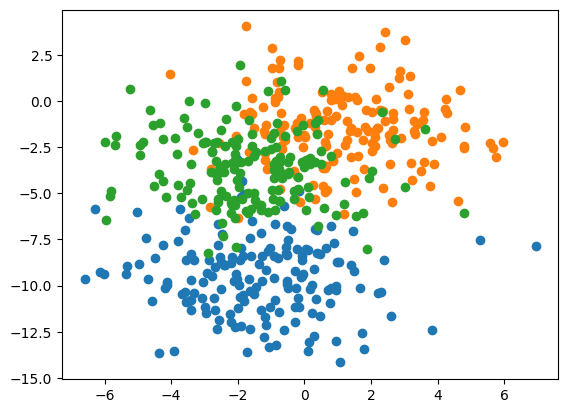

In [2]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.show()

Train: 0.860, Test: 0.797


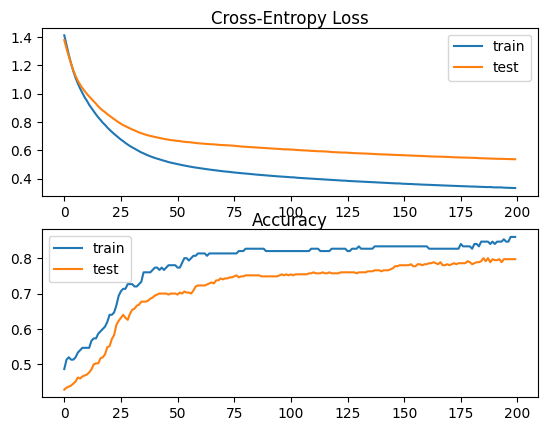

In [5]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)
# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

**model averaging ensemble**

**Grid Search weight values**

In [ ]:
# grid search for coefficients in a weighted average ensemble for the blobs problem
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product

# fit model on dataset
def fit_model(trainX, trainy):
  trainy_enc = to_categorical(trainy)
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit model
  model.fit(trainX, trainy_enc, epochs=500, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # weighted sum across ensemble members
  summed = tensordot(yhats, weights, axes=((0),(0)))
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
  # make prediction
  yhat = ensemble_predictions(members, weights, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
  # calculate l1 vector norm
  print ("unnorm", weights)
  result = norm(weights, 1)
  print ("norm", result)
  # check for a vector of all zeros
  if result == 0.0:
    return weights
  # return normalized vector (unit norm)
  return weights / result

# grid search weights
def grid_search(members, testX, testy):
  # define weights to consider
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  best_score, best_weights = 0.0, None
  # iterate all possible combinations (cartesian product)
  for weights in product(w, repeat=len(members)):
    # skip if all weights are equal
    if len(set(weights)) == 1:
      continue
    # hack, normalize weight vector
    weights = normalize(weights)
    # evaluate weights
    score = evaluate_ensemble(members, weights, testX, testy)
    if score > best_score:
      best_score, best_weights = score, weights
      print('>%s %.3f' % (best_weights, best_score))
      return list(best_weights)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
  _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
  print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
print (weights)
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

In [ ]:
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution

# fit model on dataset
def fit_model(trainX, trainy):
  trainy_enc = to_categorical(trainy)
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit model
  model.fit(trainX, trainy_enc, epochs=500, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # weighted sum across ensemble members
  summed = tensordot(yhats, weights, axes=((0),(0)))
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
  # make prediction
  yhat = ensemble_predictions(members, weights, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
  # calculate l1 vector norm
  result = norm(weights, 1)
  # check for a vector of all zeros
  if result == 0.0:
    return weights
  # return normalized vector (unit norm)
  return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
  # normalize weights
  normalized = normalize(weights)
  # calculate error rate
  return 1.0 - evaluate_ensemble(members, normalized, testX, testy)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
  _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
  print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, testX, testy)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 4ms/step
